# Decision Trees

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import os
import pydot
import eli5

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from IPython.display import Image


The classification goal is predicting if the client will subscribe to a term deposit https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification 

In [45]:
data = pd.read_csv('./data/banking_train.csv')


In [46]:
data.sample(5)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
1818,27,admin.,single,university.degree,no,yes,yes,cellular,jul,mon,150,4,999,0,nonexistent,no
12375,32,services,married,high.school,no,no,no,cellular,apr,mon,259,3,999,0,nonexistent,no
29005,28,admin.,single,university.degree,no,no,no,cellular,may,tue,118,1,999,2,failure,no
7986,26,management,single,university.degree,no,yes,no,cellular,mar,thu,119,1,999,0,nonexistent,yes
4288,29,admin.,single,high.school,no,yes,no,cellular,apr,thu,733,1,999,0,nonexistent,yes


In [47]:
data.shape


(32950, 16)

In [48]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


There are now missing values.

In [49]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
age,32950.0,40.014112,10.403636,17.0,32.0,38.0,47.0,98.0
duration,32950.0,258.127466,258.975917,0.0,103.0,180.0,319.0,4918.0
campaign,32950.0,2.560607,2.752326,1.0,1.0,2.0,3.0,56.0
pdays,32950.0,962.052413,187.951096,0.0,999.0,999.0,999.0,999.0
previous,32950.0,0.174719,0.499025,0.0,0.0,0.0,0.0,7.0


Look at our target column

In [50]:
data['y'].value_counts()


no     29238
yes     3712
Name: y, dtype: int64

In [51]:
data['y'].value_counts(normalize=True)


no     0.887344
yes    0.112656
Name: y, dtype: float64

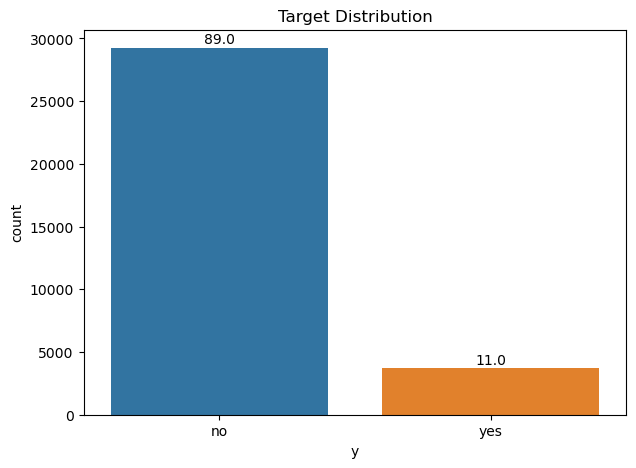

In [5]:
plt.figure(figsize=(7,5))
ax= sns.countplot(x=data['y'])
plt.title("Target Distribution")

#adding the text labels
rects = ax.patches
labels = np.round(data['y'].value_counts(normalize=True).values * 100)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 100, label, ha='center', va='bottom')

plt.show()


This dataset is unbalansed by target, so for validation we need split by using stratify.

# Visualisation

Look at categorical variables

In [52]:
data.describe(include="object").T


,count,unique,top,freq
job,32950,12,admin.,8314
marital,32950,4,married,19953
education,32950,8,university.degree,9736
default,32950,3,no,26007
housing,32950,3,yes,17254
loan,32950,3,no,27131
contact,32950,2,cellular,20908
month,32950,10,may,11011
day_of_week,32950,5,thu,6857
poutcome,32950,3,nonexistent,28416


In [53]:
black_list=['y']
cat_feats = data.select_dtypes(include= ["object"]).columns.to_list()
cat_feats = [feat for feat in cat_feats if feat not in black_list]
cat_feats


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

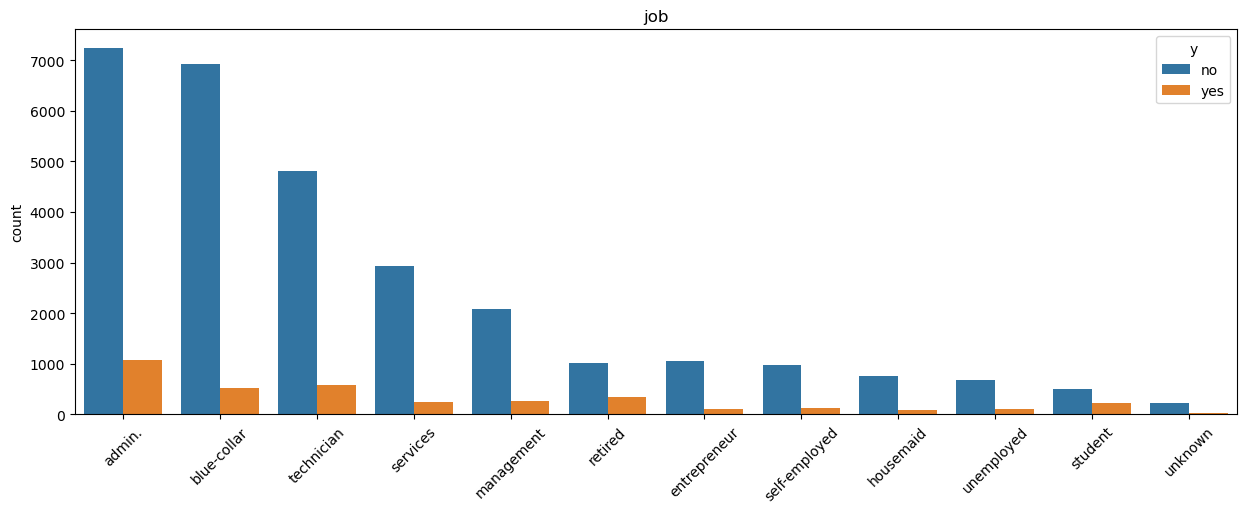

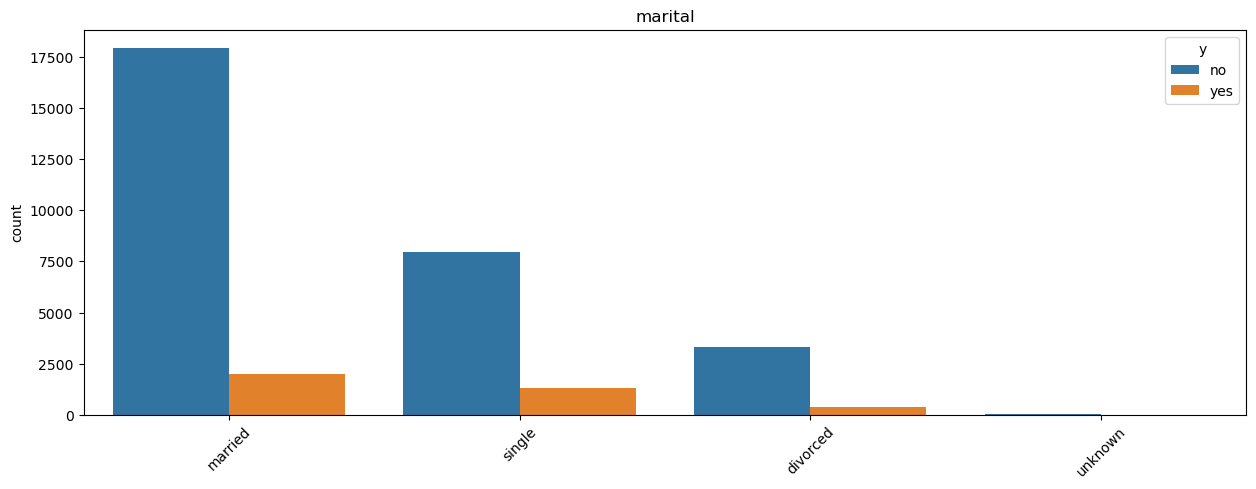

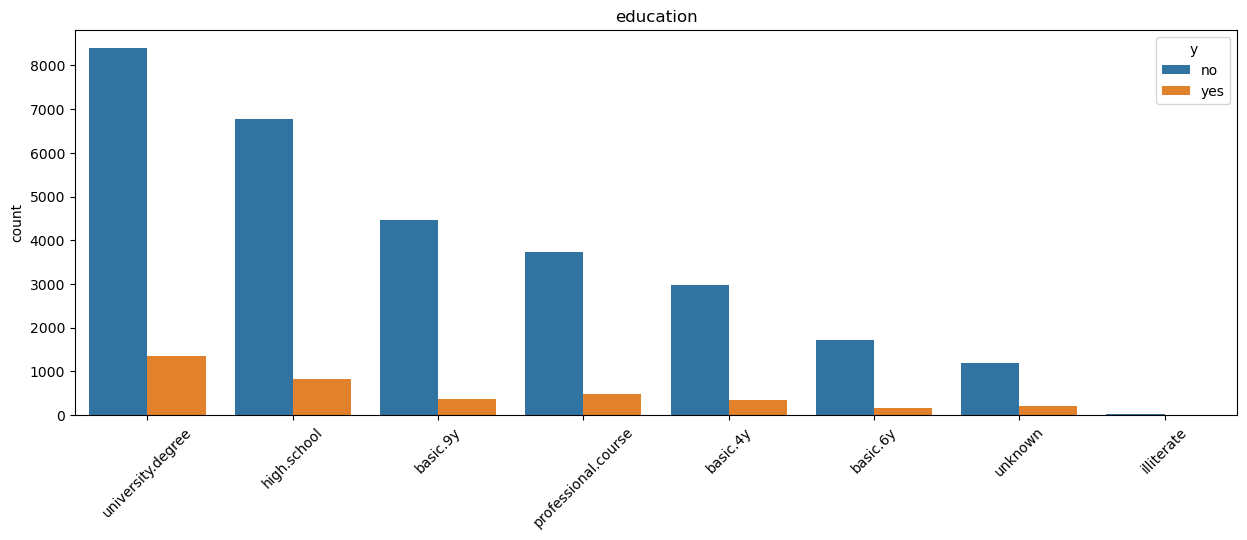

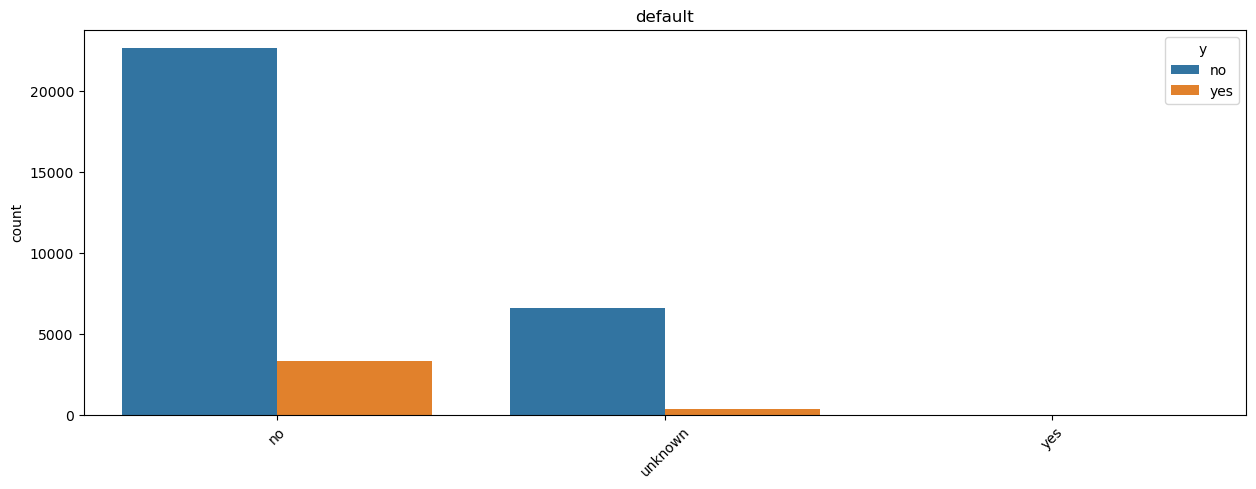

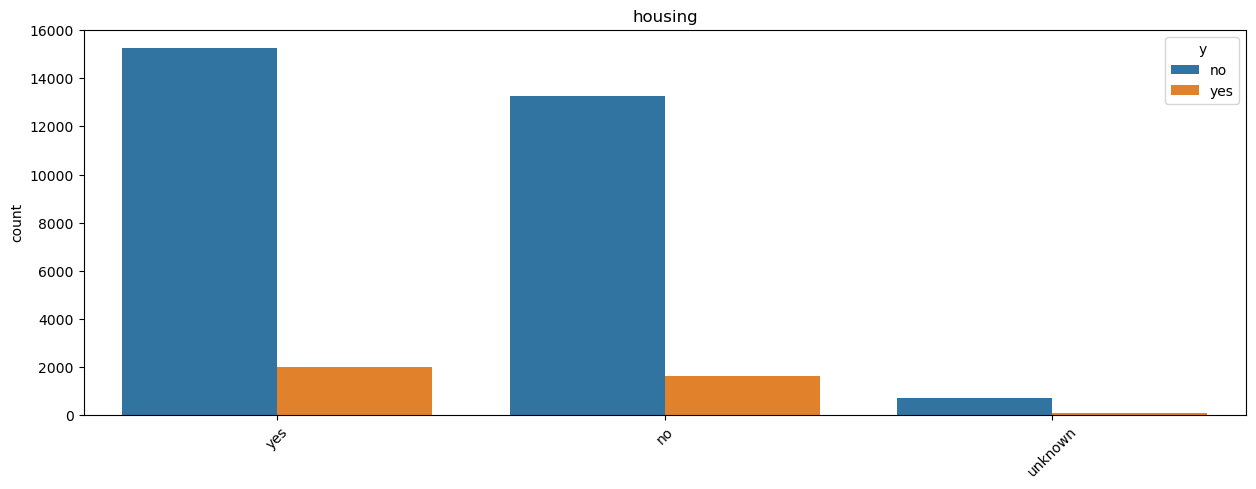

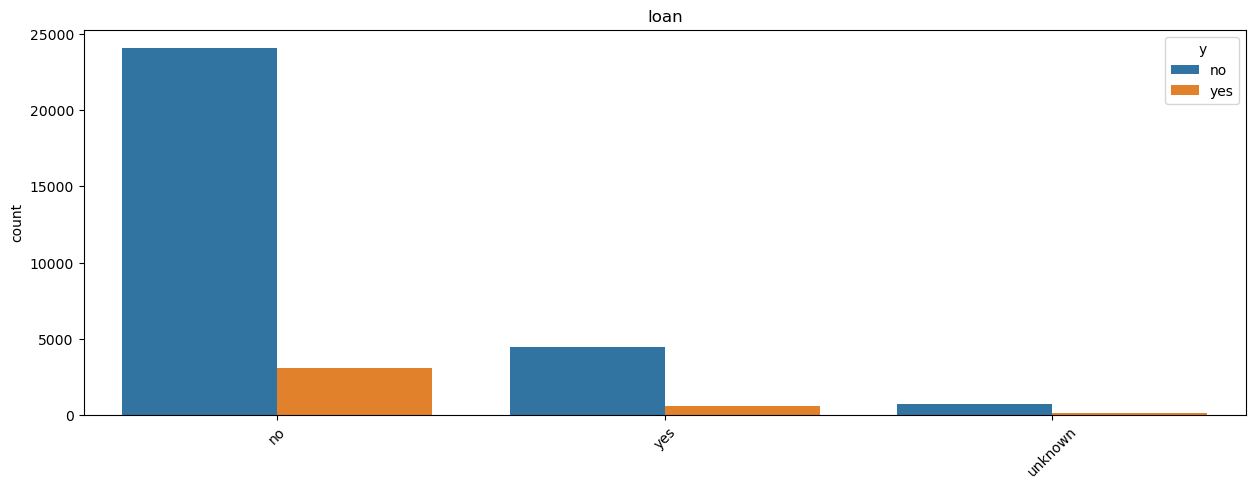

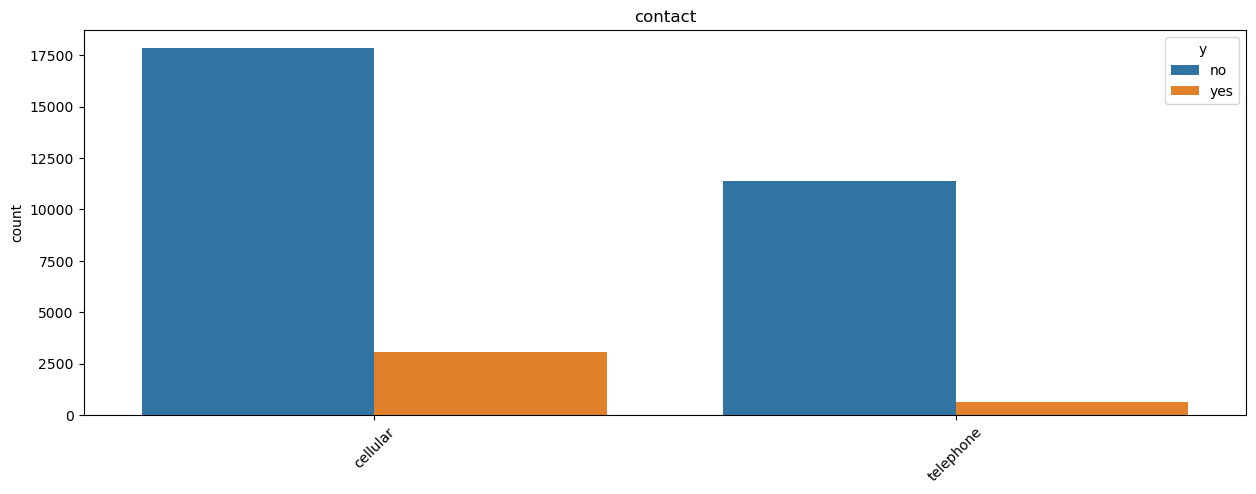

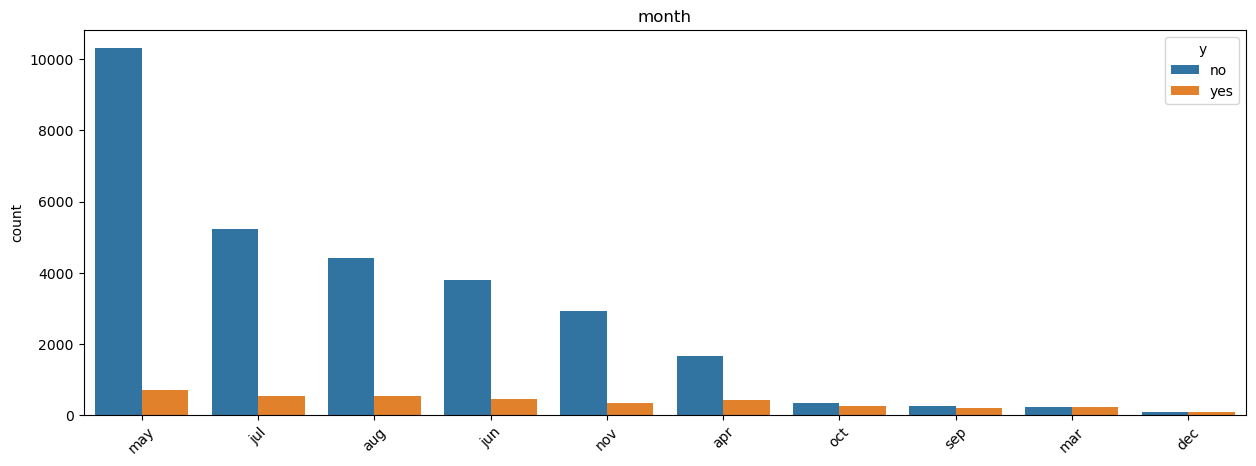

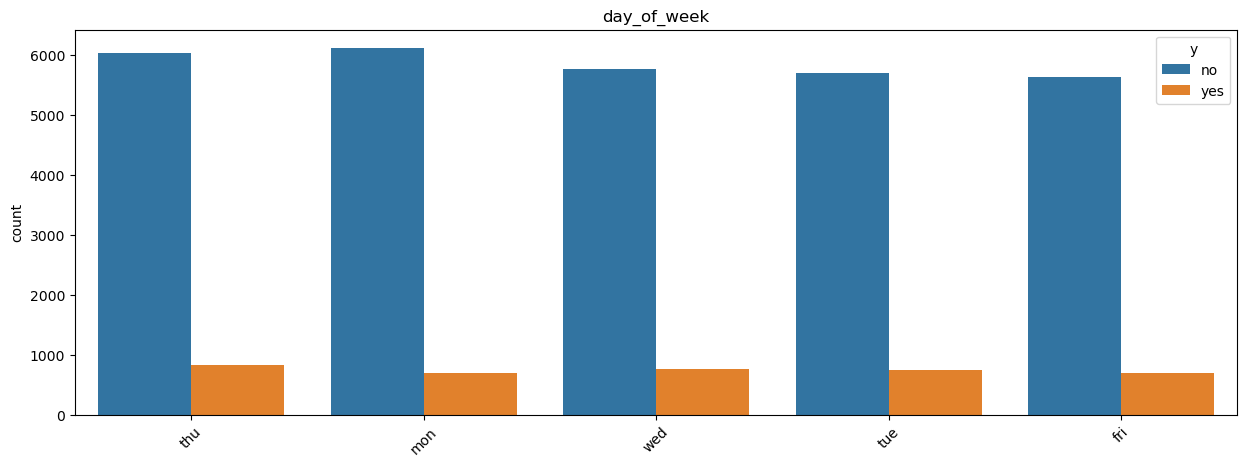

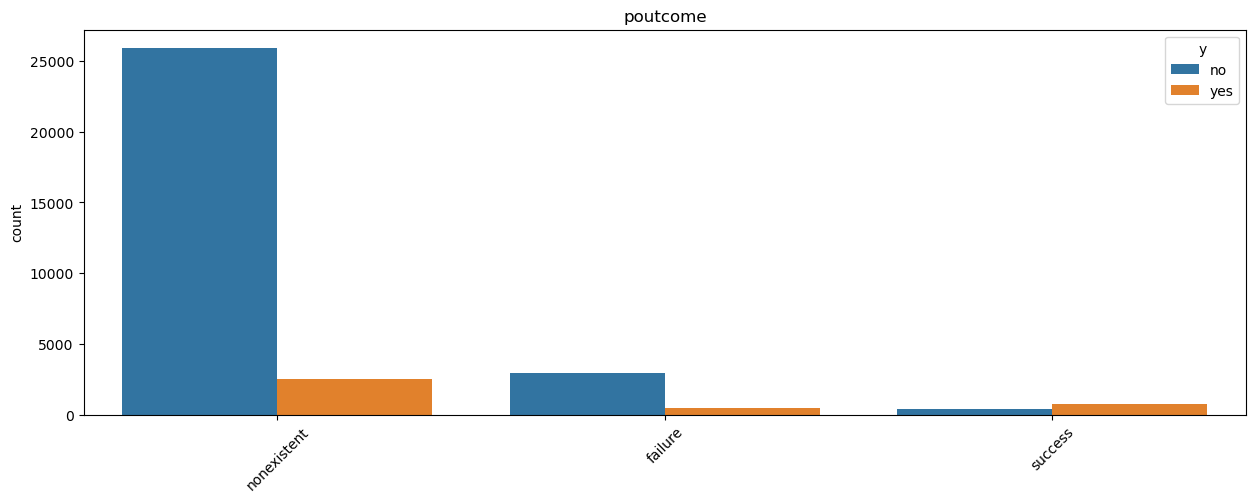

In [7]:
for feat in cat_feats:
    plt.figure(figsize=(15, 5))
    plt.xticks(rotation=45)
    sns.countplot(x=feat, data=data[cat_feats], hue=data["y"], order=data[feat].value_counts().index)
    plt.xlabel("")
    plt.title(feat)


`Job` has 12 unique values. The top three professions: administration, blue-collar jobs and technicians.

`Marital` has 4 unique values and the most of the clients are 'married'. 

`Education`: The top education levels: university, high school. More than 30% of the clients have a university degree and the rest has at least basic 4 years of education. 

`Default` Credit: has 3 unique values. Most of the clients do not have any credit

`Housing` loan: Almost 50% of the clients have housing loan and the clients who does not have housing loan are about the same ratio.

`Personal` Loan: Most of the clients do not have personal loans.

`Month`: Many customers have been contacted in the month of May. We have high values for the (nov, jul, may, jun, aug) months.

`Day of week` have uniform distribution.

`Prev_attempt`: It is very evident that most of the clients are not even contacted.

In [54]:
num_feats = data.select_dtypes('number').columns.to_list()
num_feats = [feat for feat in num_feats if feat not in black_list]
num_feats


['age', 'duration', 'campaign', 'pdays', 'previous']

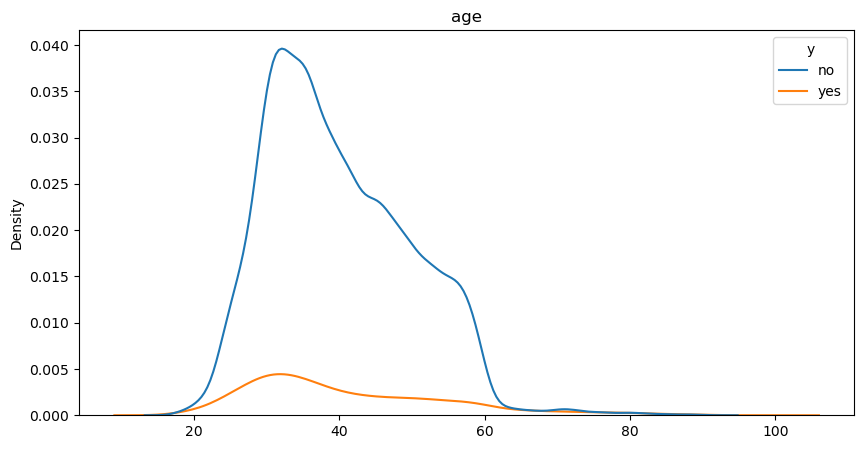

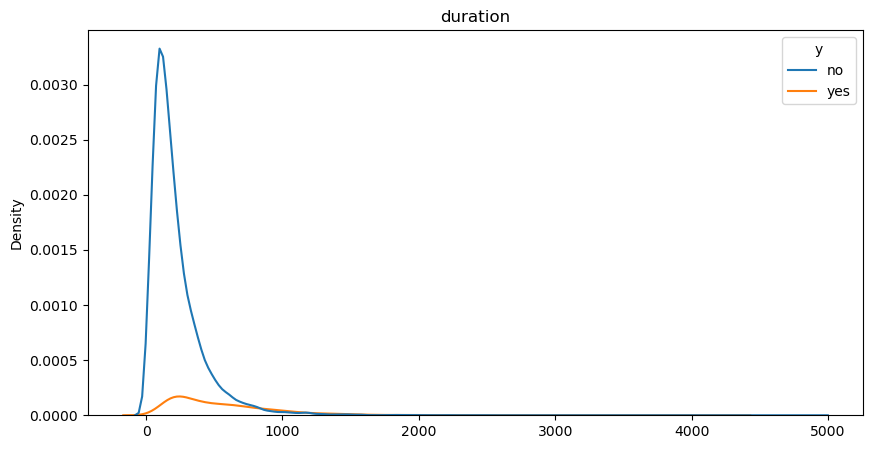

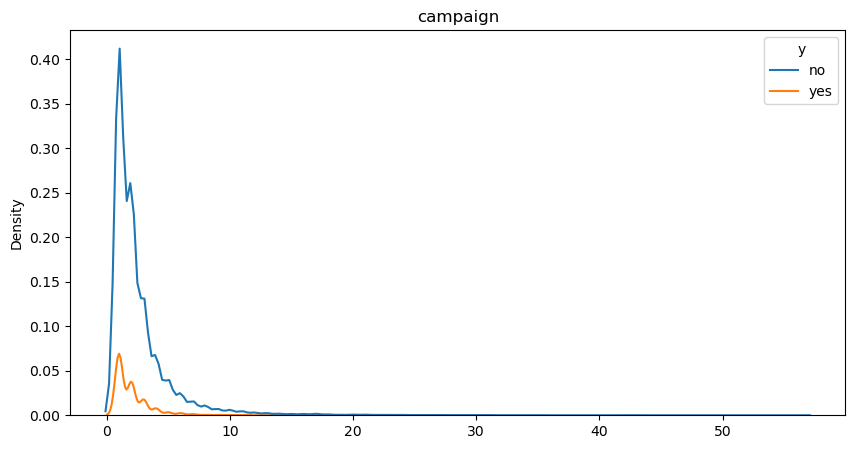

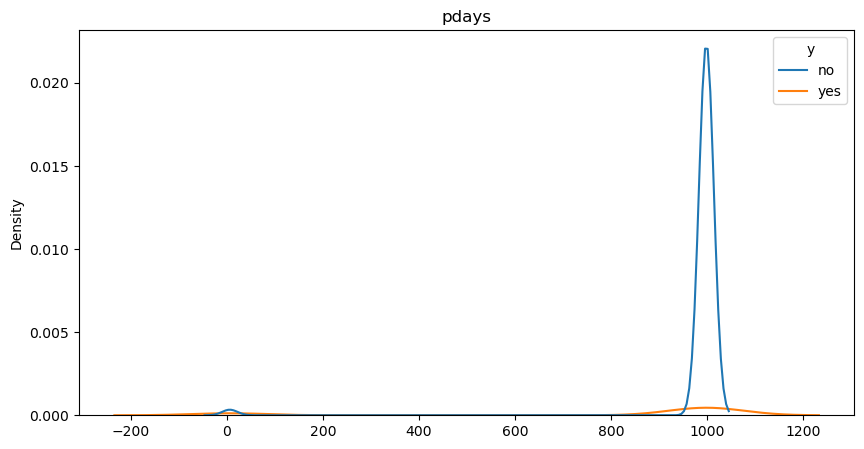

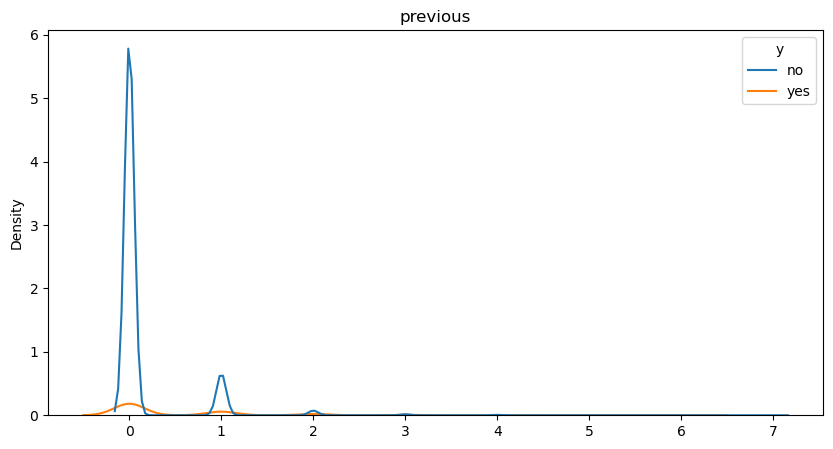

In [9]:
for feat in num_feats:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(x=feat, data=data[num_feats], hue=data["y"])
    plt.xlabel("")
    plt.title(feat)


The features `age`, `duration` and `campaign` are heavily skewed.
Looking at the plot for pdays, we can infer that majority of the customers were being contacted for the first time because as per the feature description for pdays the value 999 indicates that the customer had not been contacted previously.

Dataset is very skewed. 

### First basic model

In [55]:
# Convert yes/no to 1/0
data['y'] = pd.Series(np.where(data['y'].values == 'yes', 1, 0))
data['y'].value_counts()


0    29238
1     3712
Name: y, dtype: int64

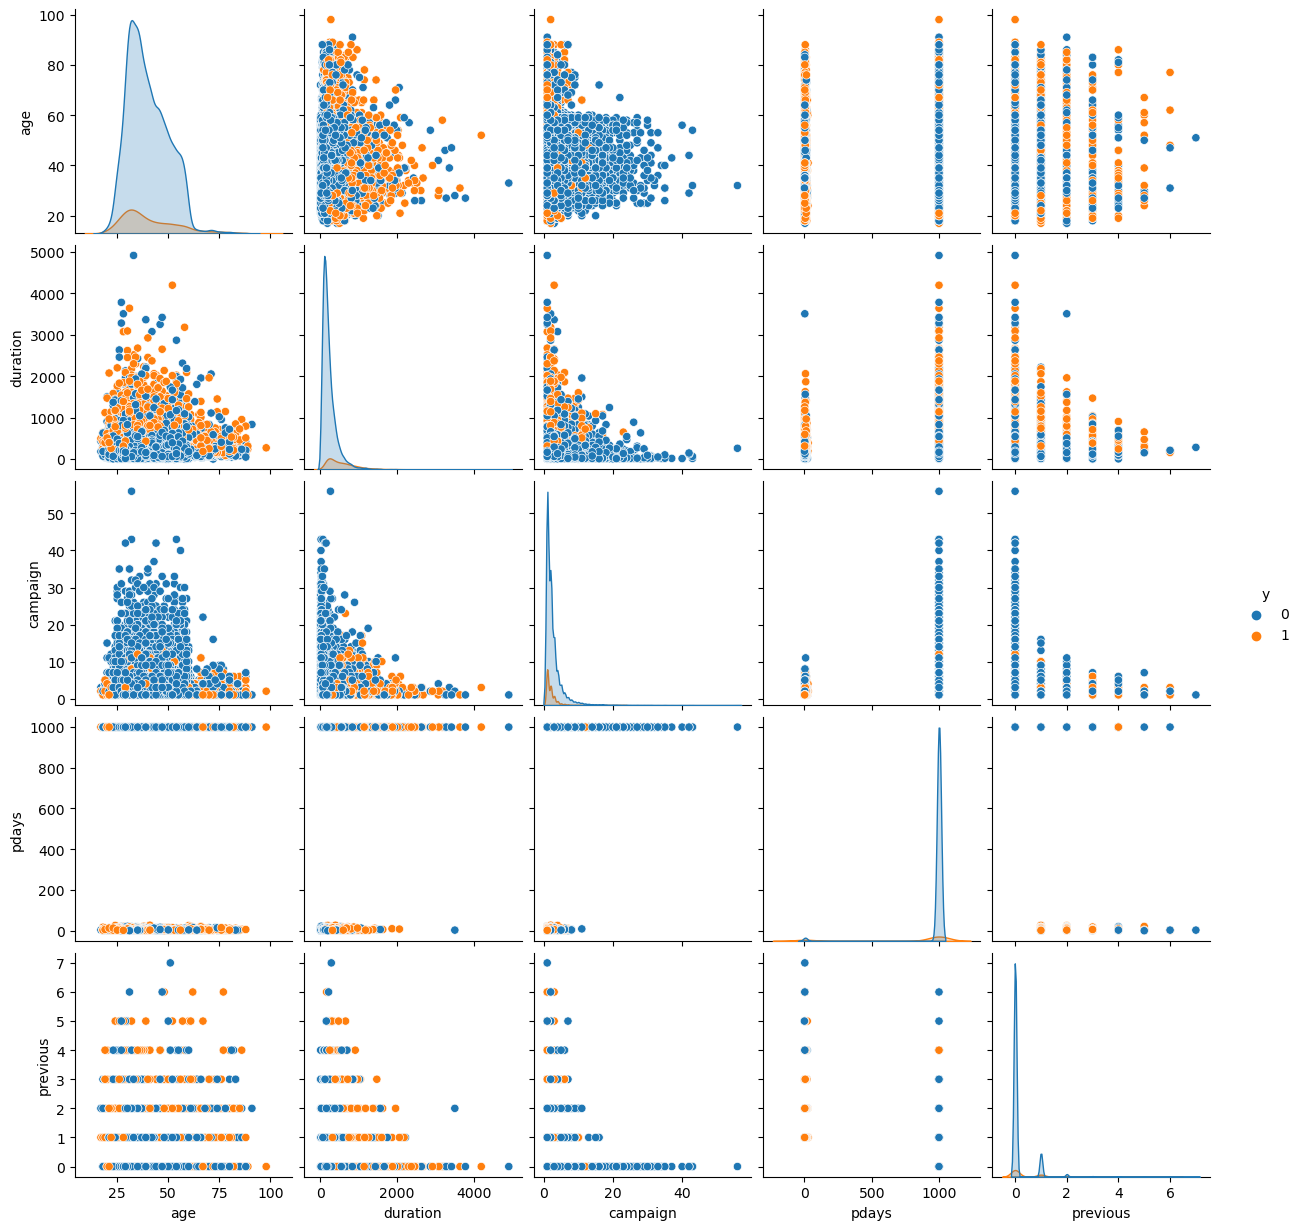

In [11]:
sns.pairplot(data, hue='y');


Dataset is not too large and unbalanced, so we can use Stratified K-fold Cross-validation. 

There is no test dataset, so create it separating 20% from the dataset to run the model only once to find out the final result. 

Use the `roc_auc` metric because we need to identify the most promising clients for working with them.

In [56]:
X, y = data.drop('y', axis = 1), data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=y)
X_train.shape, X_test.shape


((26360, 15), (6590, 15))

In [57]:
def train_model(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
    cv_score = np.mean(cross_val_score(model, X, y, cv=skf, scoring='roc_auc'))
    return cv_score


In [58]:
for max_depth in [3, 5, 7, 10, 12, 15]:
    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=24)
    cv_score = train_model(classifier, X_train.select_dtypes('number'), y_train)
    print(f'max_depth={max_depth}, roc_auc_score={cv_score}')


max_depth=3, roc_auc_score=0.7922920958192442
max_depth=5, roc_auc_score=0.8619534737426999
max_depth=7, roc_auc_score=0.8592153903291141
max_depth=10, roc_auc_score=0.8272566048111152
max_depth=12, roc_auc_score=0.7813645936347947
max_depth=15, roc_auc_score=0.7220537281033219


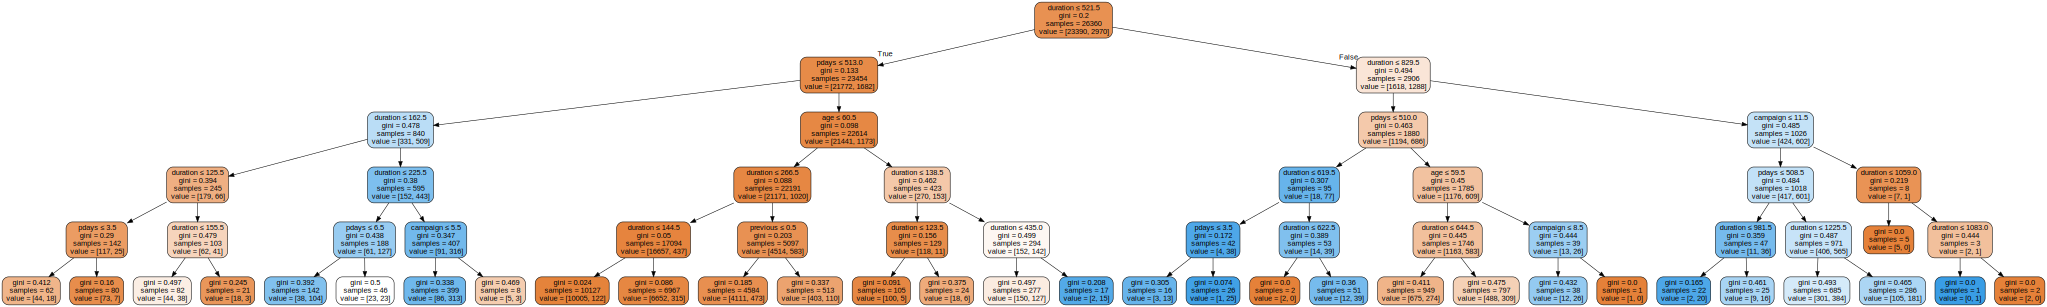

In [59]:
classifier = DecisionTreeClassifier(max_depth=5, random_state=24)
classifier.fit(X_train.select_dtypes('number'), y_train)
dot_data = export_graphviz(classifier,
                  feature_names=X_train.select_dtypes('number').columns.values,
                  filled=True, rounded=True,
                  special_characters=True,
                )
graph = graphviz.Source(dot_data)

graph


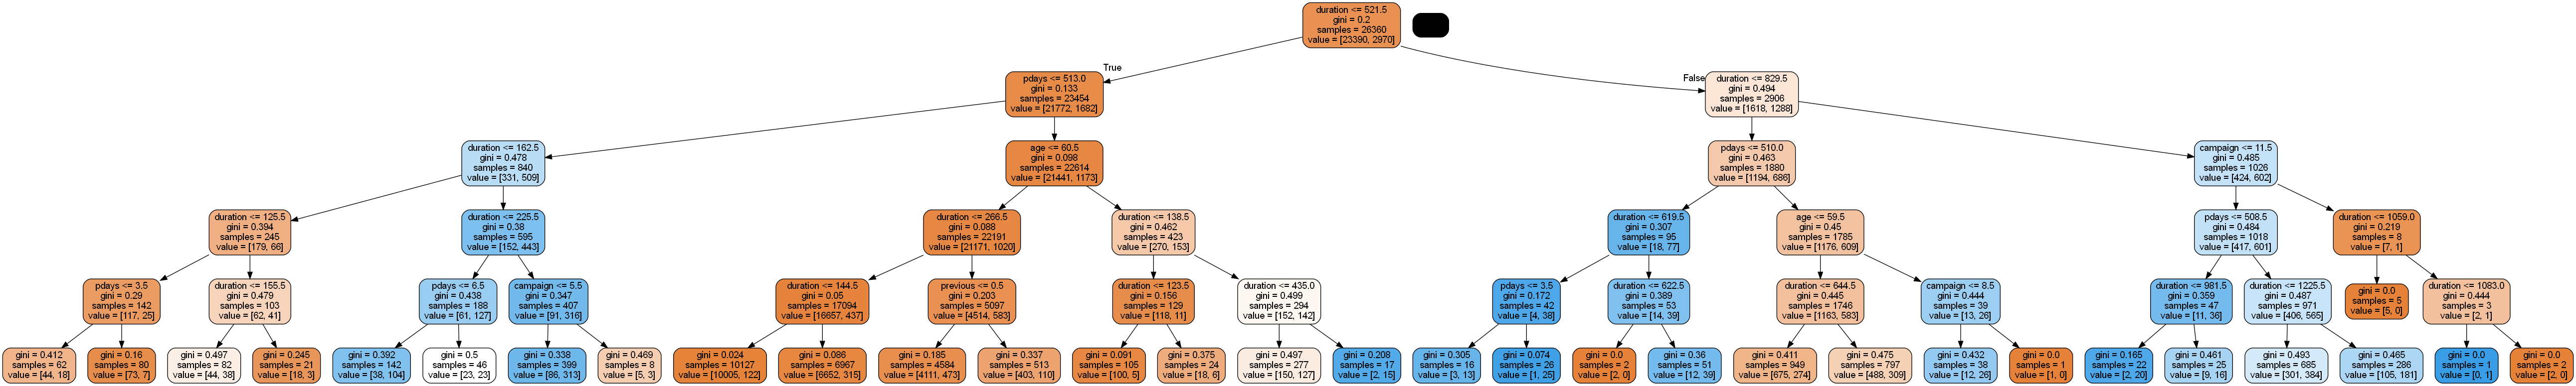

In [60]:
IMAGES_PATH = r'./data/'

classifier = DecisionTreeClassifier(max_depth=5, random_state=24)

classifier.fit(X_train.select_dtypes('number'), y_train)
export_graphviz(
    classifier,
    feature_names=X_train.select_dtypes('number').columns.values,
    out_file=os.path.join(IMAGES_PATH, 'small_tree.dot'),
    filled=True,
    rounded=True
)

(graph, ) = pydot.graph_from_dot_file('./data/small_tree.dot')
graph.write_png('./data/small_tree.png')

# visualize obtained tree structure
Image('./data/small_tree.png', width=1800, height=1080)


In [61]:
classifier = DecisionTreeClassifier(max_depth=5, random_state=24)
classifier.fit(X_train.select_dtypes('number'), y_train)
eli5.show_weights(classifier, feature_names=X_train.select_dtypes('number').columns.values)


Weight,Feature
0.6021,duration
0.3315,pdays
0.0553,age
0.0069,previous
0.0042,campaign


### Encoding the categorical data


In [62]:
cat_feats


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [63]:
data_enc=data.copy()

le = LabelEncoder()
data_enc[cat_feats] = data_enc[cat_feats].apply(lambda col: le.fit_transform(col))

data_enc.sample(3)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
13921,51,0,1,6,0,2,0,1,6,4,223,3,999,0,1,0
22544,34,4,2,6,0,2,0,1,7,4,111,2,999,1,0,0
9870,49,1,1,3,1,2,0,0,1,2,199,1,999,0,1,0


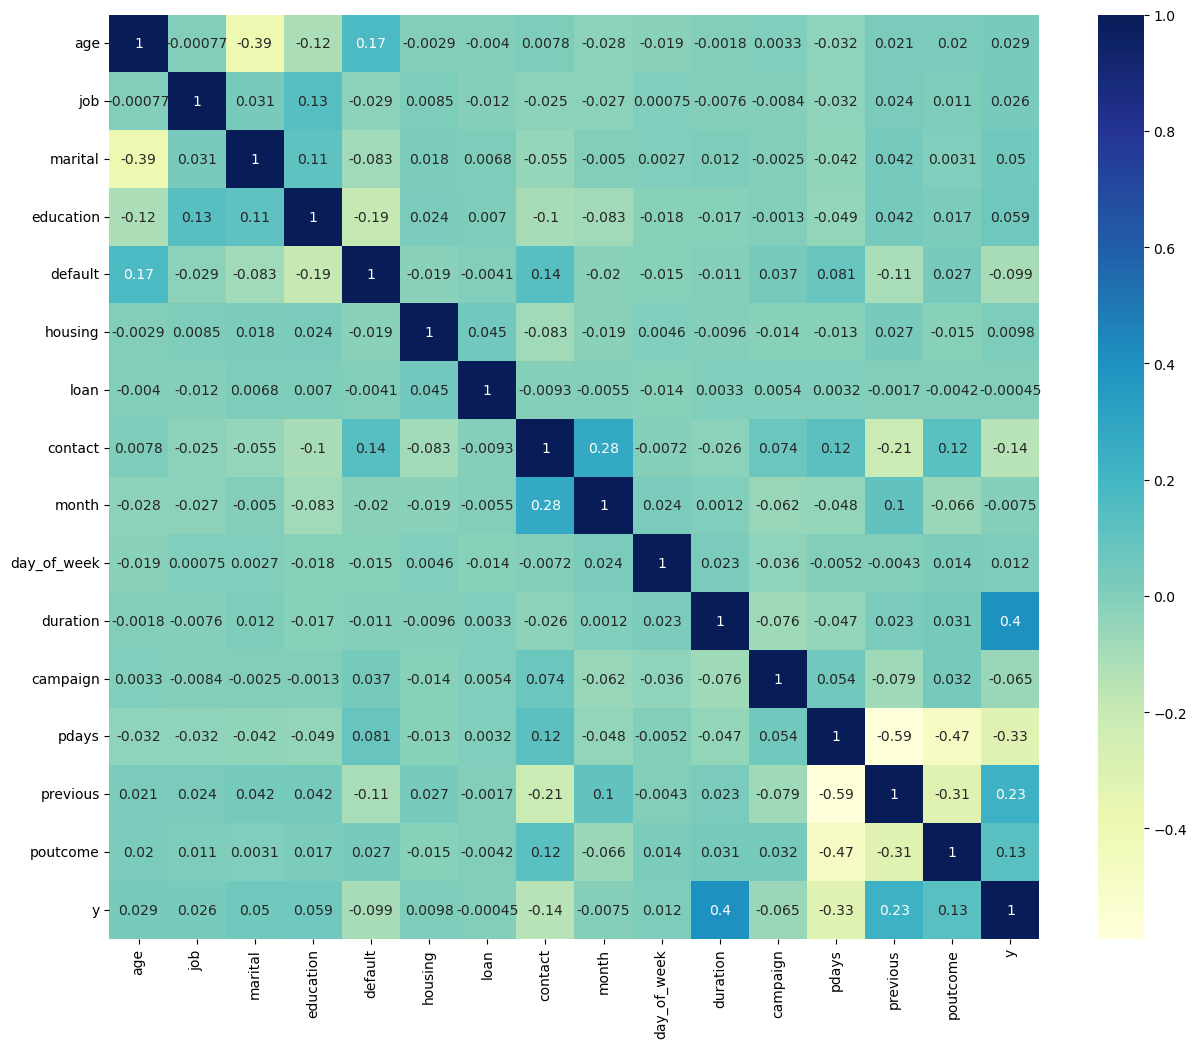

In [31]:
plt.figure(figsize=(15,12))
sns.heatmap(data_enc.corr(), annot=True, cmap="YlGnBu")
plt.show()


In [64]:
def get_train_test(df):
    X, y = df.drop('y', axis = 1), df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test


In [65]:
X_train, X_test, y_train, y_test = get_train_test(data_enc)


In [66]:
print(f"y_train:\n {y_train.value_counts(normalize=True)}")
print(f"y_test:\n {y_test.value_counts(normalize=True)}")


y_train:
 0    0.887329
1    0.112671
Name: y, dtype: float64
y_test:
 0    0.887405
1    0.112595
Name: y, dtype: float64


In [67]:
for max_depth in [3, 5, 7, 10, 12, 15]:
    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=24)
    print(f'max_depth={max_depth}, f1_score={train_model(classifier, X_train, y_train)}')


max_depth=3, f1_score=0.7948648160383945
max_depth=5, f1_score=0.8598630598416831
max_depth=7, f1_score=0.8679545202631992
max_depth=10, f1_score=0.8283646641705641
max_depth=12, f1_score=0.7908377993991504
max_depth=15, f1_score=0.7459485117672376


It seem like Label / OneHot Encoding will be a good way for this task.

In [68]:
X_train, X_test, y_train, y_test = get_train_test(data)


In [69]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), cat_features), # encode categorical features as a combination of binary features
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    DecisionTreeClassifier(max_depth=7, random_state=24)
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
np.mean(cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc'))


0.8556733790808181

In [70]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
model = make_pipeline(
    make_column_transformer(
        (OrdinalEncoder(), cat_features), # encode categorical features as a combination of binary features
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    DecisionTreeClassifier(max_depth=7, random_state=24)
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
np.mean(cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc'))


0.8676572263895906

Label Encoding is better

Try another approach: columns `'job'`, `'education'`, `'contact'`, `'month'` and `'day_of_week'` encoding by using Label Encoding (OrdinalEncoder) and `'marital'`, `'default'`, `'housing'`, `'loan'`, `'poutcome'` by One Hot Encoding.

In [71]:
label_enc_col = ['job', 'education', 'contact', 'month', 'day_of_week']
one_hot_enc_col = ['marital', 'default', 'housing', 'loan', 'poutcome']

model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), one_hot_enc_col), # encode categorical features
        (OrdinalEncoder(), label_enc_col),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    DecisionTreeClassifier(max_depth=7, random_state=24)
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
np.mean(cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc'))


0.8675350843478249

Got a very similar result

In [84]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), one_hot_enc_col), # encode categorical features
        (OrdinalEncoder(), label_enc_col),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    DecisionTreeClassifier(random_state=24)
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "decisiontreeclassifier__max_depth": [3, 5, 7, 10, 15],
    "decisiontreeclassifier__min_samples_leaf": [1, 3, 5, 7],
    "decisiontreeclassifier__criterion": ['gini', 'entropy'],
    "decisiontreeclassifier__class_weight": ['balanced', {1:3},{1:5},{1:7},{1:10},{1:12},{1:15},{1:20}]
}

gcv = GridSearchCV(model, param_grid, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc')
gcv.fit(X_train, y_train)


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['marital',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'poutcome']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['job',
                                                                          'education',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week'])],
                                                          v...
                                        DecisionTreeClassifier(random_state=24))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__class_weight': ['balanced',
                                                                  {1: 3},
                                                                  {1: 5},
                                                                  {1: 7},
                                                                  {1: 10},
                                                                  {1: 12},
                                                                  {1: 15},
                                                                  {1: 20}],
                         'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 5, 7, 10, 15],
                         'decisiontreeclassifier__min_samples_leaf': [1, 3, 5,
                                                                      7]},
             scoring='roc_auc', verbose=1)

In [85]:
gcv.best_estimator_, gcv.best_score_


(Pipeline(steps=[('columntransformer',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('onehotencoder',
                                                   OneHotEncoder(),
                                                   ['marital', 'default',
                                                    'housing', 'loan',
                                                    'poutcome']),
                                                  ('ordinalencoder',
                                                   OrdinalEncoder(),
                                                   ['job', 'education',
                                                    'contact', 'month',
                                                    'day_of_week'])],
                                    verbose_feature_names_out=False)),
                 ('decisiontreeclassifier',
                  DecisionTreeClassifier(class_weight={1: 20},
                       

In [86]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), one_hot_enc_col), # encode categorical features
        (OrdinalEncoder(), label_enc_col),
        remainder='passthrough',
        verbose_feature_names_out=False
    ),
    DecisionTreeClassifier(class_weight={1: 20},
                           criterion='entropy', max_depth=7,
                           min_samples_leaf=7,
                           random_state=24)
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
np.mean(cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc'))


0.8919569789385949

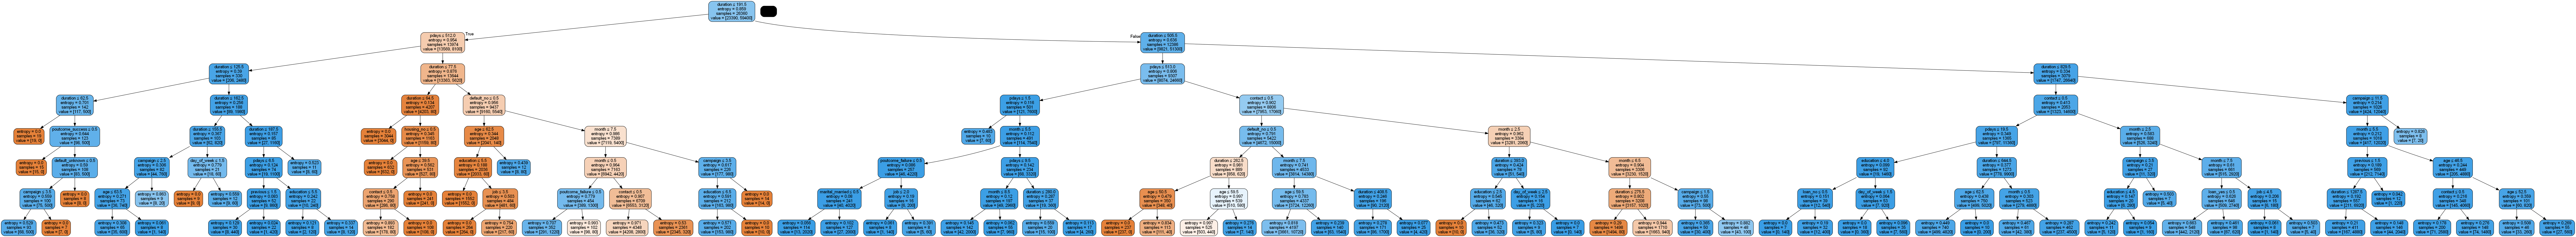

In [87]:
model.fit(X_train, y_train)
dot_data = export_graphviz(
    model[1],
    feature_names=model[:-1]. get_feature_names_out(),
    out_file=os.path.join(IMAGES_PATH, 'small_tree_two.dot'),
    filled=True, rounded=True,
    special_characters=True,
)

(graph, ) = pydot.graph_from_dot_file('./data/small_tree_two.dot')
graph.write_png('./data/small_tree_two.png')

# visualize obtained tree structure
Image('./data/small_tree_two.png', width=1800, height=1080)


In [88]:
predict = model.predict(X_test)
print(classification_report(y_test, predict))


              precision    recall  f1-score   support

           0       0.98      0.72      0.83      5848
           1       0.29      0.89      0.44       742

    accuracy                           0.74      6590
   macro avg       0.64      0.81      0.63      6590
weighted avg       0.90      0.74      0.79      6590



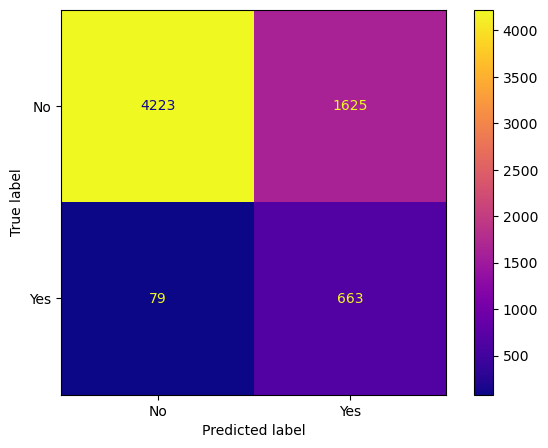

In [89]:
plt.rcParams['figure.figsize'] = 7, 5
cm = confusion_matrix(y_test, predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap=plt.cm.plasma);
plt.show()
